In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score, RocCurveDisplay
#remove following if not used
from statistics import stdev
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

In [6]:
# NEW CODE (reading from the data folder)
data = pd.read_csv('../data/diabetes_prediction_dataset.csv')

In [7]:
samples, features = data.shape
print('Number Of Samples: ', samples)
print('Number Of Features: ', features)

Number Of Samples:  100000
Number Of Features:  9


In [8]:
data.head(10)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
5,Female,20.0,0,0,never,27.32,6.6,85,0
6,Female,44.0,0,0,never,19.31,6.5,200,1
7,Female,79.0,0,0,No Info,23.86,5.7,85,0
8,Male,42.0,0,0,never,33.64,4.8,145,0
9,Female,32.0,0,0,never,27.32,5.0,100,0


In [9]:
data.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [10]:
data.duplicated().sum()
data = data.drop_duplicates()

In [11]:
samples, features = data.shape
print('Number Of Samples: ', samples)
print('Number Of Features: ', features)

Number Of Samples:  96146
Number Of Features:  9


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def column_outlier_counts(df, features):
    outlier_counts = {}

    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
        outlier_counts[feature] = len(outliers)

    # Plot
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(outlier_counts.keys()), y=list(outlier_counts.values()), palette="flare")
    plt.title("Number of Outliers per Feature (IQR Method)")
    plt.ylabel("Outlier Count")
    plt.xlabel("Feature")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return pd.DataFrame.from_dict(outlier_counts, orient='index', columns=['Outlier Count'])


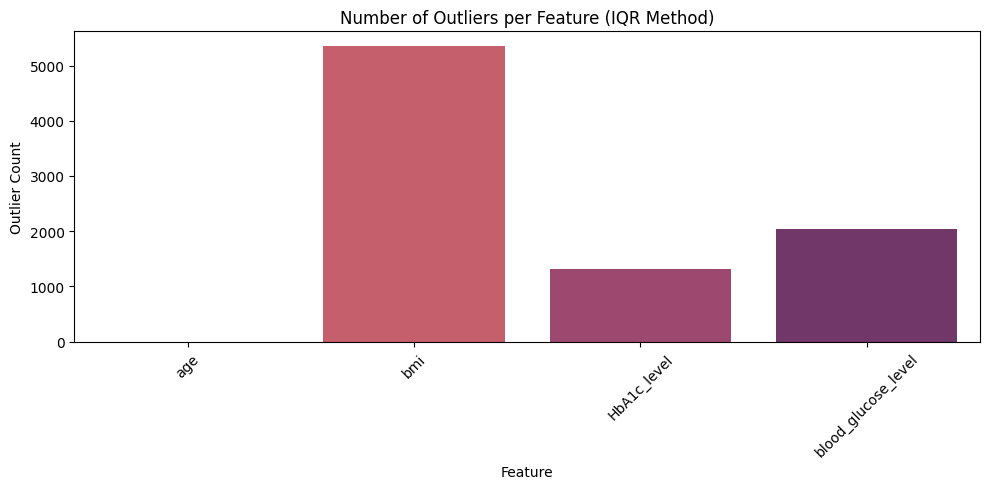

,Outlier Count
age,0
bmi,5354
HbA1c_level,1312
blood_glucose_level,2031


In [14]:
# Define numeric columns for outlier detection
numeric_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
column_outlier_counts(data, numeric_features)


In [15]:
def remove_outliers_iqr(df, features, log=True):

    cleaned_df = df.copy()
    initial_rows = cleaned_df.shape[0]
    outlier_mask = pd.Series([False] * len(cleaned_df), index=cleaned_df.index)

    for feature in features:
        Q1 = cleaned_df[feature].quantile(0.25)
        Q3 = cleaned_df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        feature_outliers = (cleaned_df[feature] < lower_bound) | (cleaned_df[feature] > upper_bound)
        outlier_mask |= feature_outliers

    removed_df = cleaned_df[outlier_mask]
    cleaned_df = cleaned_df[~outlier_mask]

    if log:
        print(f"Initial rows: {initial_rows}")
        print(f"Final rows after outlier removal: {cleaned_df.shape[0]}")
        print(f"Rows removed: {initial_rows - cleaned_df.shape[0]}")

    return cleaned_df, removed_df


In [16]:
# Define numeric columns for outlier detection
numeric_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

# Apply IQR filtering
cleaned_data, removed_rows = remove_outliers_iqr(data, numeric_features)


Initial rows: 96146
Final rows after outlier removal: 88195
Rows removed: 7951


In [17]:
samples, features = data.shape
print('Number Of Samples: ', samples)
print('Number Of Features: ', features)

Number Of Samples:  96146
Number Of Features:  9


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def outlier_visual_dashboard(original_df, cleaned_df, features):

    sns.set(style="whitegrid")
    n = len(features)

    for feature in features:
        fig, axes = plt.subplots(2, 2, figsize=(14, 8))

        # Boxplots
        sns.boxplot(x=original_df[feature], ax=axes[0, 0], color='salmon')
        axes[0, 0].set_title(f'{feature} Boxplot (Before)')

        sns.boxplot(x=cleaned_df[feature], ax=axes[0, 1], color='mediumseagreen')
        axes[0, 1].set_title(f'{feature} Boxplot (After)')

        # Histograms
        sns.histplot(original_df[feature], kde=True, ax=axes[1, 0], color='salmon')
        axes[1, 0].set_title(f'{feature} Histogram (Before)')

        sns.histplot(cleaned_df[feature], kde=True, ax=axes[1, 1], color='mediumseagreen')
        axes[1, 1].set_title(f'{feature} Histogram (After)')

        plt.suptitle(f"Outlier Visualization for '{feature}'", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


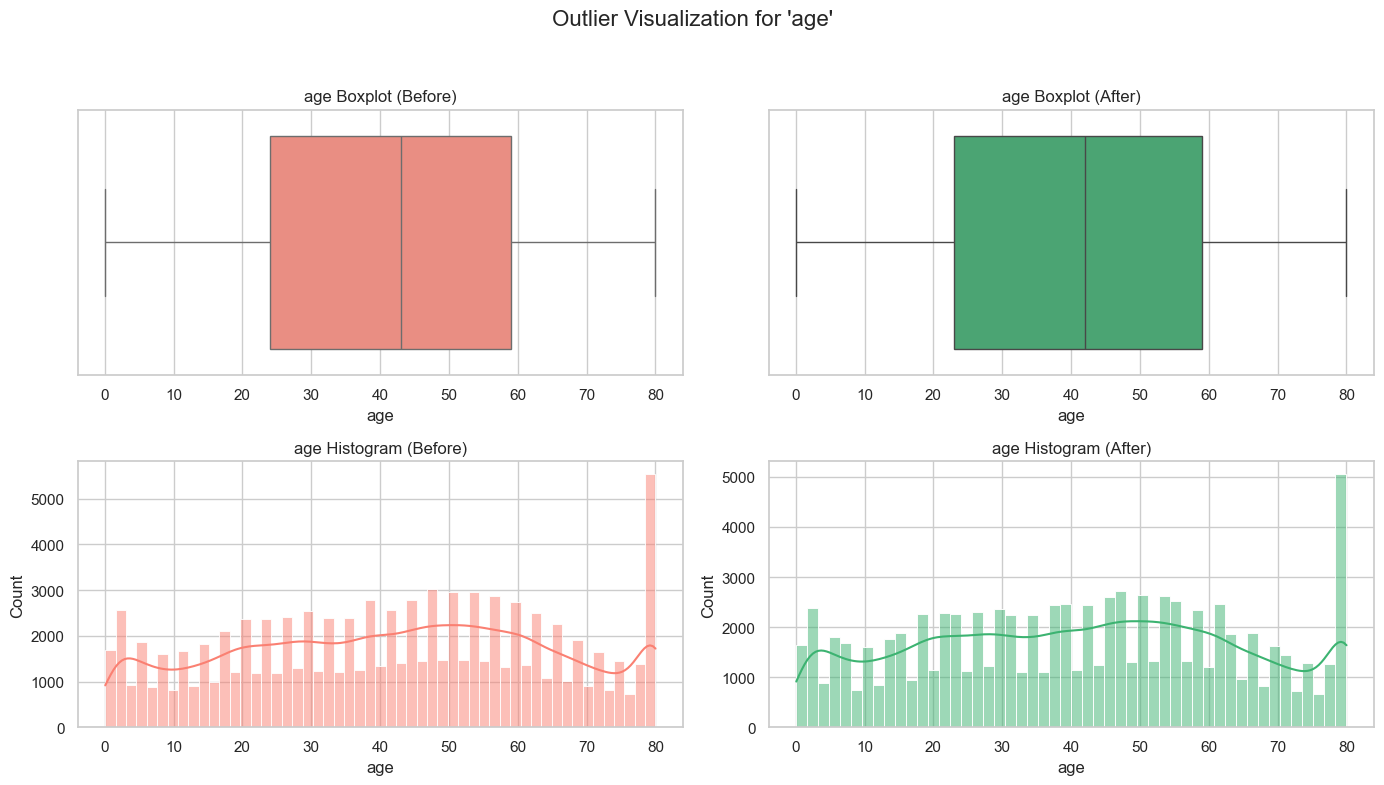

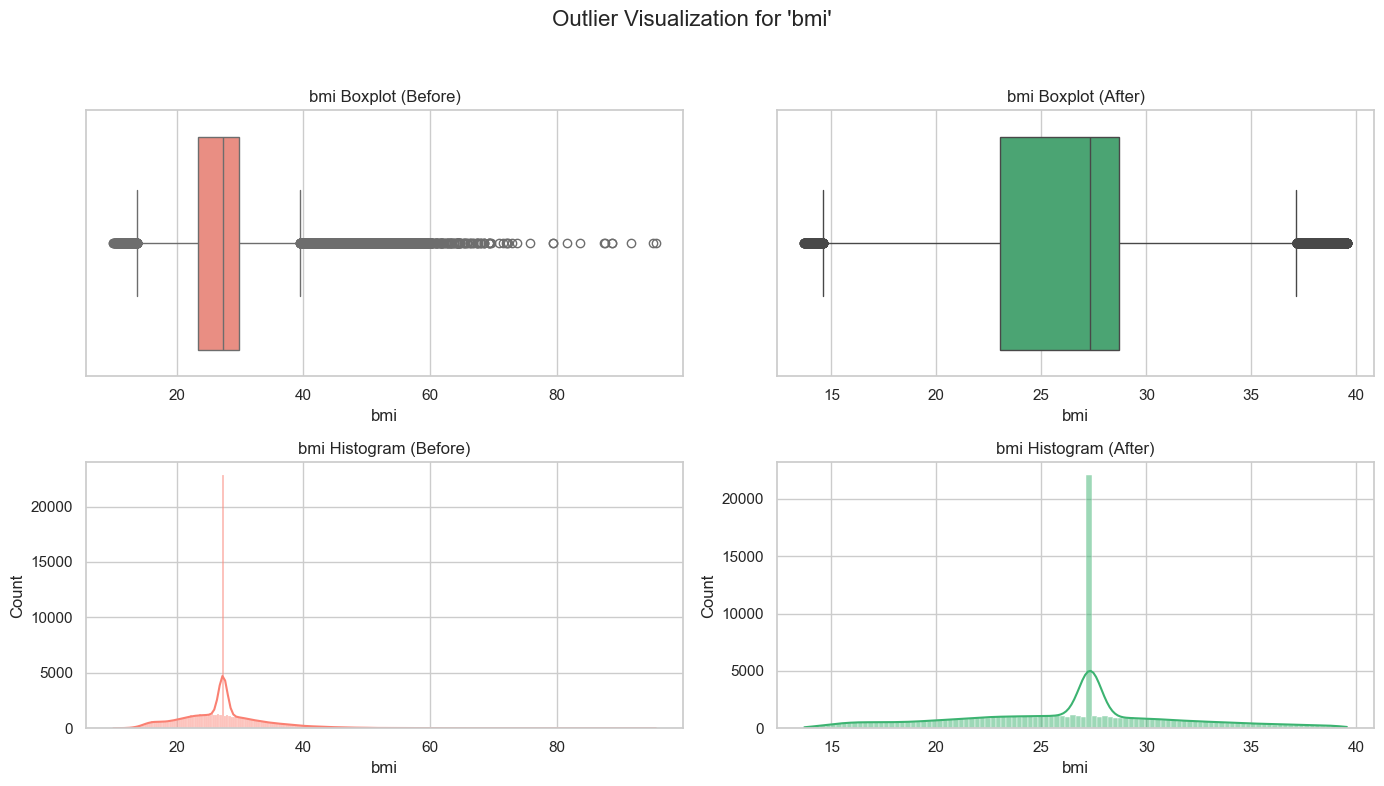

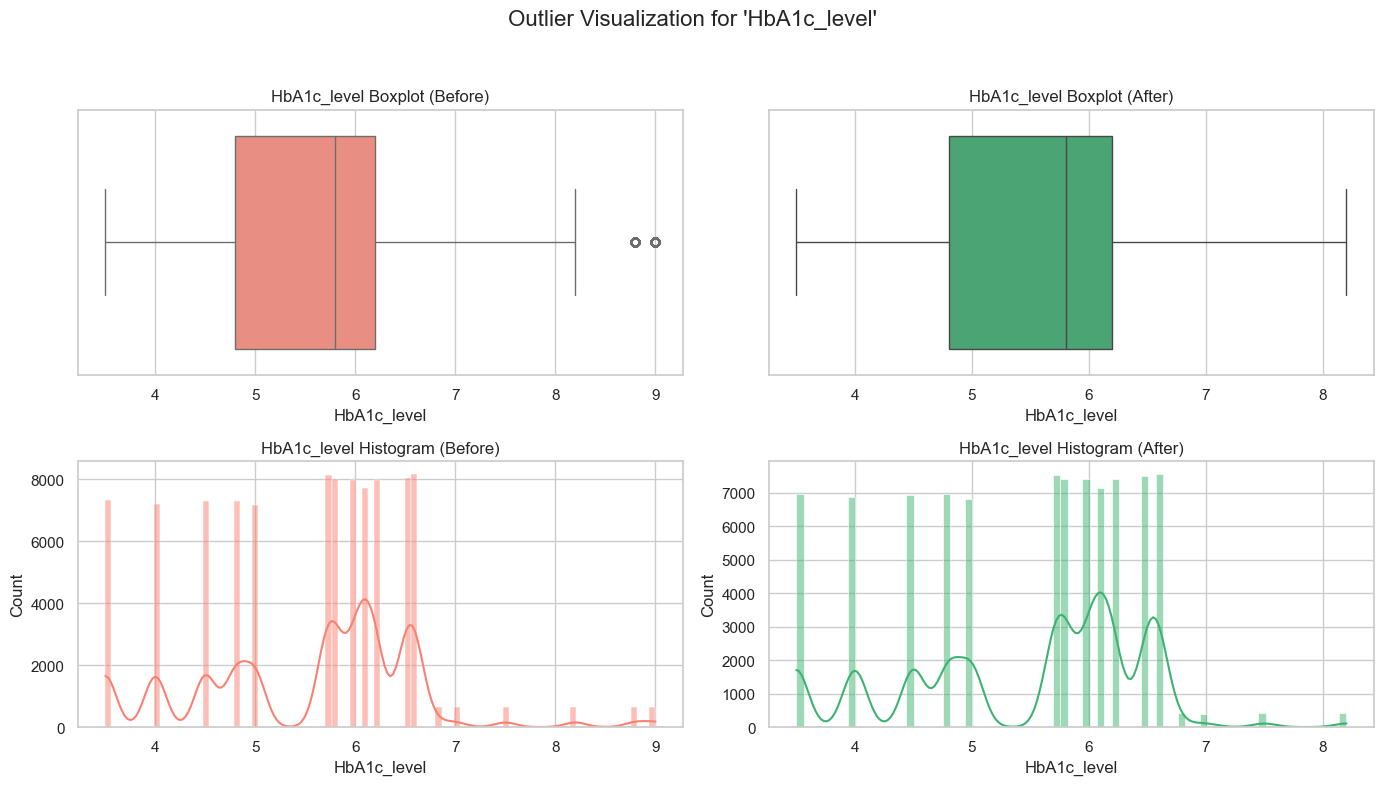

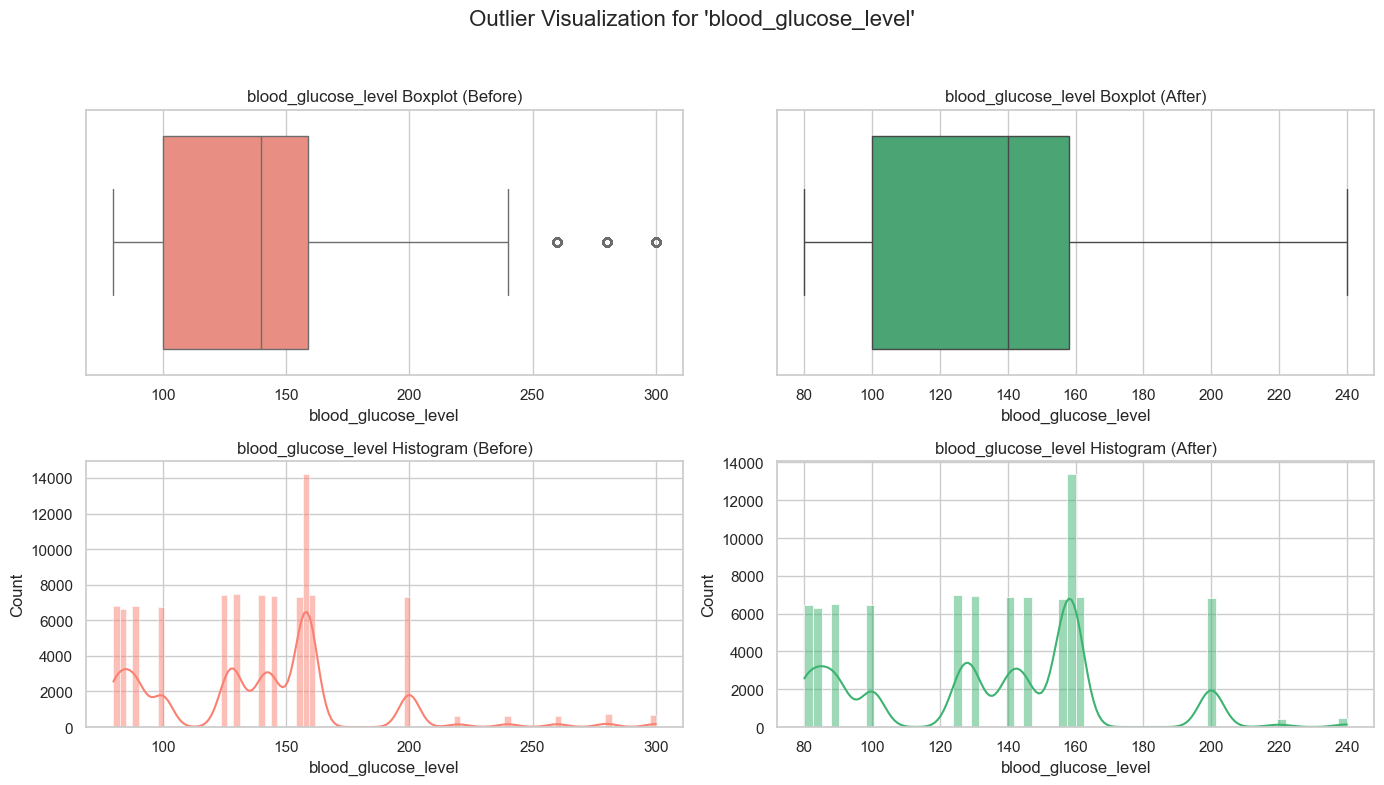

In [19]:
outlier_visual_dashboard(data, cleaned_data, numeric_features)


In [20]:
data = cleaned_data
data.shape

(88195, 9)

In [21]:
data = pd.get_dummies(data, columns=['smoking_history', 'gender'], drop_first=True)


In [22]:
print(data.columns)


Index(['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level',
       'blood_glucose_level', 'diabetes', 'smoking_history_current',
       'smoking_history_ever', 'smoking_history_former',
       'smoking_history_never', 'smoking_history_not current', 'gender_Male',
       'gender_Other'],
      dtype='object')


In [23]:
target = data['diabetes']
data.drop('diabetes', axis=1, inplace=True)


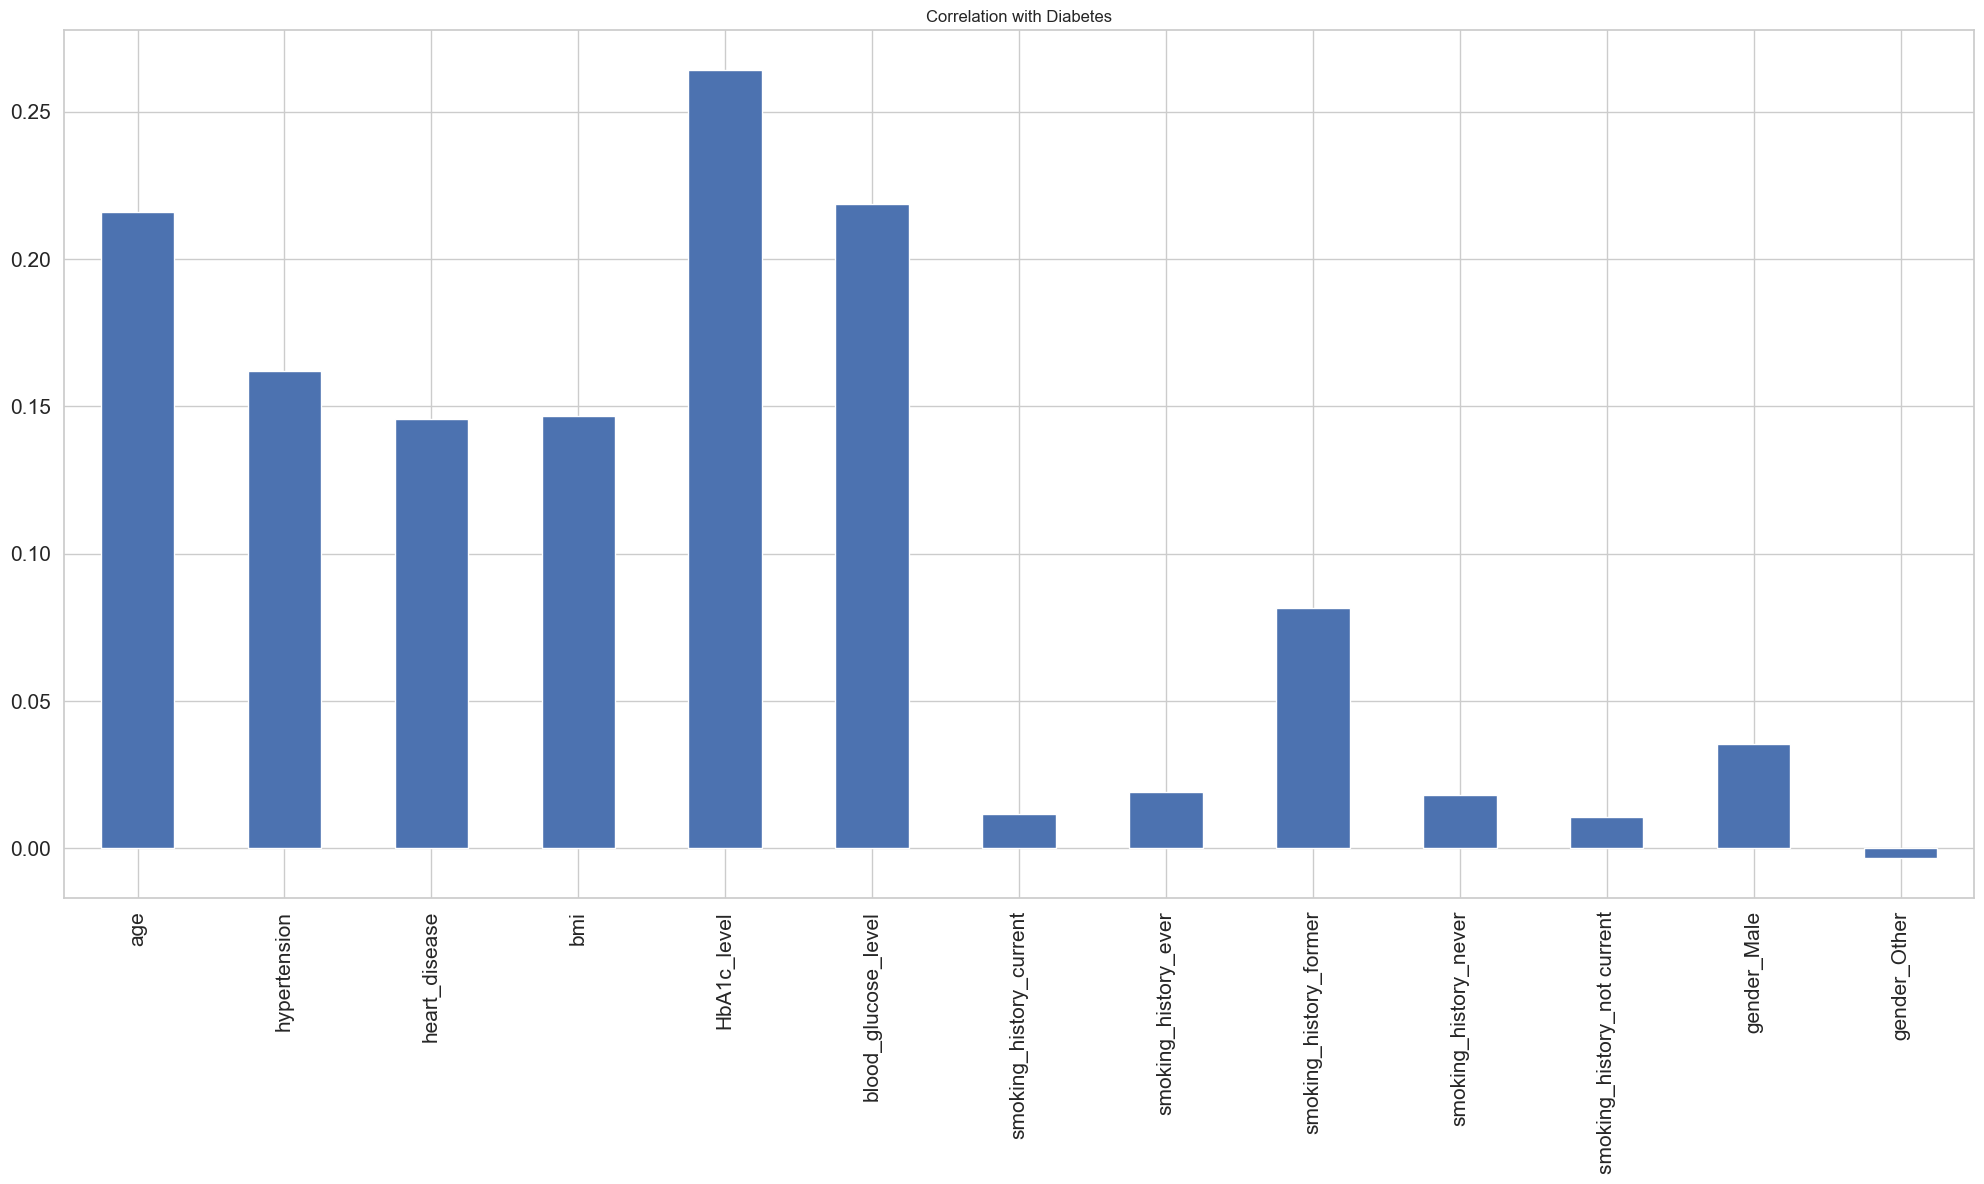

In [24]:
import matplotlib.pyplot as plt

# Compute and plot correlation
correlations = data.corrwith(target)
correlations.plot.bar(
    figsize=(20, 12), title='Correlation with Diabetes',
    fontsize=15, rot=90, grid=True)

plt.tight_layout()
plt.savefig('5.png')  # Use proper extension
plt.show()


# **Dataset Spiltting**

In [25]:
xtrain, xtest, ytrain, ytest = train_test_split(data, target, test_size=0.30, random_state=42)

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def metrics_calculator(y_test, y_pred, model_name, y_proba=None):

    result = pd.DataFrame(data=[
                                accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, average='macro'),
                                recall_score(y_test, y_pred, average='macro'),
                                f1_score(y_test, y_pred, average='macro'),
                                roc_auc_score(y_test, y_proba[:,1]) if y_proba is not None else None
                               ],
                          index=['Accuracy','Precision','Recall','F1-score', 'ROC AUC'],
                          columns = [model_name])
    return result


In [27]:
cols = xtrain.columns  # Save column names before scaling

scaler = StandardScaler()  # Initialize scaler

# Create scaled versions and keep the originals untouched
xtrain_scaled = pd.DataFrame(scaler.fit_transform(xtrain), columns=cols)
xtest_scaled = pd.DataFrame(scaler.transform(xtest), columns=cols)


In [73]:
# The 'cols' variable holds the exact column names after one-hot encoding
# We will save this list to a file.
columns_filepath = "../models/training_columns.pkl"
joblib.dump(cols, columns_filepath)

print(f"Training columns saved successfully to {columns_filepath}")

Training columns saved successfully to ../models/training_columns.pkl


In [72]:
import joblib

# Let's assume your scaler object is named 'scaler'
# If it has a different name, change it in the line below
scaler_to_save = scaler

scaler_filepath = "../models/scaler_v1.pkl"
joblib.dump(scaler_to_save, scaler_filepath)
print("Scaler saved successfully to ../models/scaler_v1.pkl")

Scaler saved successfully to ../models/scaler_v1.pkl


# **Model Training**

# **KNN**

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Define model and parameter grid
knn = KNeighborsClassifier()
param = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance']
}

In [29]:
# 2. Perform Grid Search
gridSearch = GridSearchCV(knn, param, cv=5, scoring='accuracy')
gridSearch.fit(xtrain_scaled, ytrain)  # ✅ Use scaled data for KNN


,estimator,KNeighborsClassifier()
,param_grid,"{'n_neighbors': [3, 5, ...], 'weights': ['uniform', 'distance']}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,7


In [30]:
# 3. Get best estimator and train it again
KNN = gridSearch.best_estimator_
KNN.fit(xtrain_scaled, ytrain)

,n_neighbors,7
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [31]:
# 4. Predict and evaluate
ypred = KNN.predict(xtest_scaled)
yproba = KNN.predict_proba(xtest_scaled)

print('Model Accuracy Score: {0:0.4f}'.format(accuracy_score(ytest, ypred)))

Model Accuracy Score: 0.9602


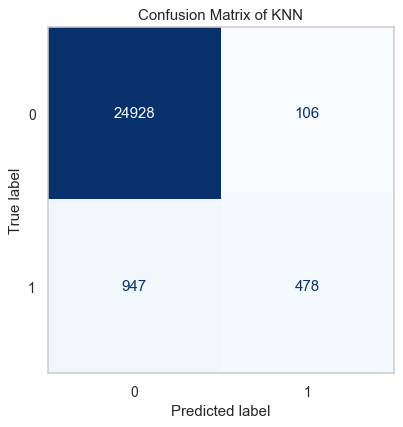

In [32]:
# 5. Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 5), dpi=90)
sns.set_style('darkgrid')
ConfusionMatrixDisplay.from_estimator(KNN, xtest_scaled, ytest, ax=ax, colorbar=False, cmap='Blues')
plt.title('Confusion Matrix of KNN')
plt.grid(False)
plt.show()

In [33]:
# 6. Metrics
knn_result = metrics_calculator(ytest, ypred, 'KNN', yproba)
print(knn_result)

                KNN
Accuracy   0.960203
Precision  0.890947
Recall     0.665602
F1-score   0.727587
ROC AUC    0.851355


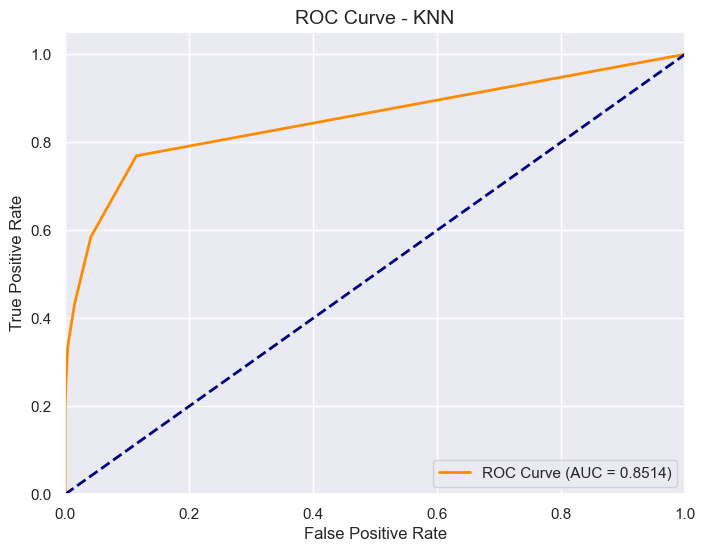

In [34]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Extract probability scores for the positive class (diabetes = 1)
fpr, tpr, thresholds = roc_curve(ytest, yproba[:, 1])
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - KNN', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# **Logistic Regression**

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Define model and parameter grid
lg = LogisticRegression(solver='saga', max_iter=1000)  # saga supports all penalties
param = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'l1_ratio': [0.5]  # Required for elasticnet
}

In [36]:
# 2. Perform Grid Search with cross-validation
gridSearch = GridSearchCV(lg, param, cv=5, scoring='accuracy', error_score='raise')
gridSearch.fit(xtrain_scaled, ytrain)

,estimator,LogisticRegre...solver='saga')
,param_grid,"{'l1_ratio': [0.5], 'penalty': ['l1', 'l2', ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,'raise'
,return_train_score,False
,penalty,'l1'


In [37]:
# 3. Get best model and train
Logistic = gridSearch.best_estimator_
Logistic.fit(xtrain_scaled, ytrain)

,penalty,'l1'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'saga'
,max_iter,1000
,multi_class,'deprecated'


In [38]:
# 4. Predict and probability
ypred = Logistic.predict(xtest_scaled)
yproba = Logistic.predict_proba(xtest_scaled)

print('Model Accuracy Score: {0:0.4f}'.format(accuracy_score(ytest, ypred)))

Model Accuracy Score: 0.9609


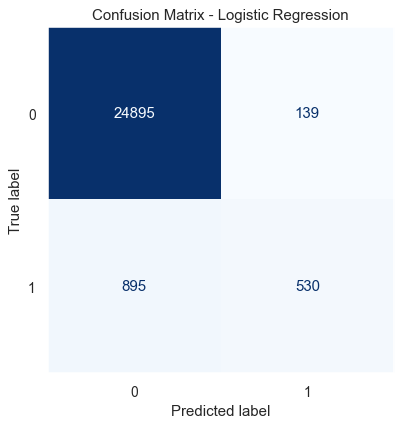

In [39]:
# 5. Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 5), dpi=90)
sns.set_style('darkgrid')
ConfusionMatrixDisplay.from_estimator(Logistic, xtest_scaled, ytest, ax=ax, colorbar=False, cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.grid(False)
plt.show()

In [40]:
# 6. Metrics
lg_result = metrics_calculator(ytest, ypred, 'Logistic Regression', yproba)
print(lg_result)


           Logistic Regression
Accuracy              0.960921
Precision             0.878762
Recall                0.683189
F1-score              0.742932
ROC AUC               0.938097


In [41]:
print("Best Parameters:", gridSearch.best_params_)


Best Parameters: {'l1_ratio': 0.5, 'penalty': 'l1'}


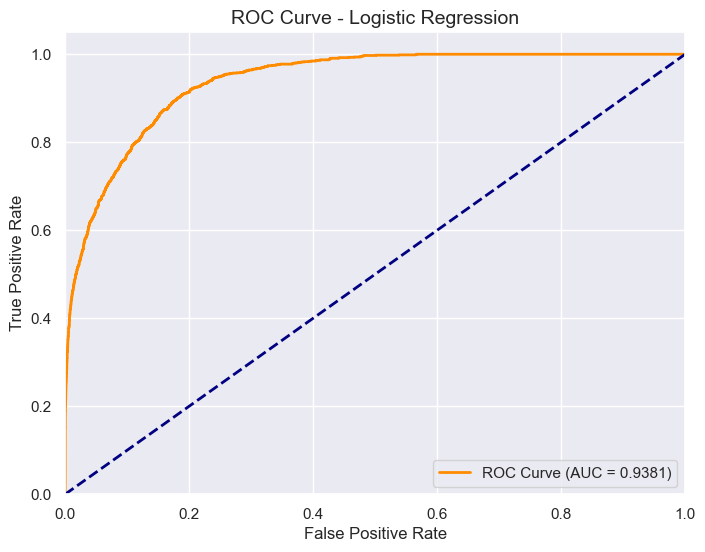

In [43]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Extract probabilities for the positive class (diabetes = 1)
fpr, tpr, thresholds = roc_curve(ytest, yproba[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Logistic Regression', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# **SVM**

In [44]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Define model and parameter grid
svm = SVC(probability=True)  # Needed to get probability scores
param = {
    'C': [0.1, 1, 10],           # Regularization
    'kernel': ['linear', 'rbf'], # Try linear and RBF kernels
    'gamma': ['scale', 'auto']   # Only used for RBF
}

In [45]:
# 2. Perform Grid Search
gridSearch = GridSearchCV(svm, param, cv=5, scoring='accuracy')
gridSearch.fit(xtrain_scaled, ytrain)

,estimator,SVC(probability=True)
,param_grid,"{'C': [0.1, 1, ...], 'gamma': ['scale', 'auto'], 'kernel': ['linear', 'rbf']}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,10


In [46]:
# 3. Train best model
SVM = gridSearch.best_estimator_
SVM.fit(xtrain_scaled, ytrain)

,C,10
,kernel,'rbf'
,degree,3
,gamma,'auto'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [47]:
# 4. Predict and probabilities
ypred = SVM.predict(xtest_scaled)
yproba = SVM.predict_proba(xtest_scaled)

print('Model Accuracy Score: {0:0.4f}'.format(accuracy_score(ytest, ypred)))

Model Accuracy Score: 0.9645


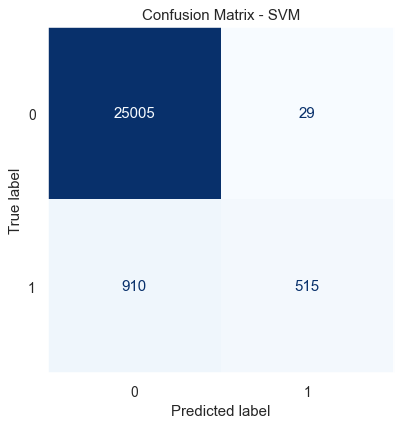

In [48]:
# 5. Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 5), dpi=90)
sns.set_style('darkgrid')
ConfusionMatrixDisplay.from_estimator(SVM, xtest_scaled, ytest, ax=ax, colorbar=False, cmap='Blues')
plt.title('Confusion Matrix - SVM')
plt.grid(False)
plt.show()

In [49]:
# 6. Metrics
svm_result = metrics_calculator(ytest, ypred, 'SVM', yproba)
print(svm_result)

                SVM
Accuracy   0.964511
Precision  0.955788
Recall     0.680123
F1-score   0.752339
ROC AUC    0.895797


In [50]:
print("Best SVM Parameters:", gridSearch.best_params_)


Best SVM Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


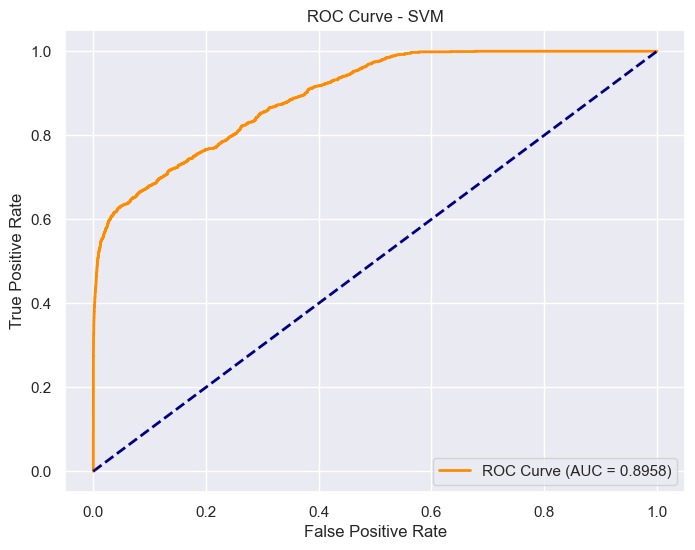

In [51]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(ytest, yproba[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC Curve - SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# **Decision Tree Classifier**

In [52]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define model and parameter grid
dt = DecisionTreeClassifier(random_state=42)
param = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

In [53]:
# 2. Grid Search
gridSearch = GridSearchCV(dt, param, cv=5, scoring='accuracy')
gridSearch.fit(xtrain_scaled, ytrain)

,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, ...], 'min_samples_split': [2, 5, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [54]:
# 3. Train best model
DT = gridSearch.best_estimator_
DT.fit(xtrain_scaled, ytrain)

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [55]:
# 4. Predict
ypred = DT.predict(xtest_scaled)
yproba = DT.predict_proba(xtest_scaled)

print('Model Accuracy Score: {0:0.4f}'.format(accuracy_score(ytest, ypred)))

Model Accuracy Score: 0.9712


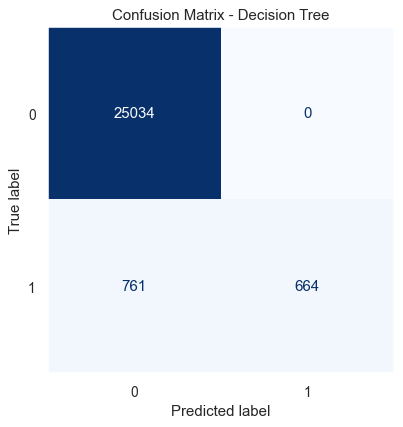

In [56]:
# 5. Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 5), dpi=90)
sns.set_style('darkgrid')
ConfusionMatrixDisplay.from_estimator(DT, xtest_scaled, ytest, ax=ax, colorbar=False, cmap='Blues')
plt.title('Confusion Matrix - Decision Tree')
plt.grid(False)
plt.show()

In [57]:
# 6. Metrics
dt_result = metrics_calculator(ytest, ypred, 'Decision Tree', yproba)
print(dt_result)

           Decision Tree
Accuracy        0.971239
Precision       0.985249
Recall          0.732982
F1-score        0.810370
ROC AUC         0.932504


In [58]:
print("Best Parameters (Decision Tree):", gridSearch.best_params_)

Best Parameters (Decision Tree): {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}


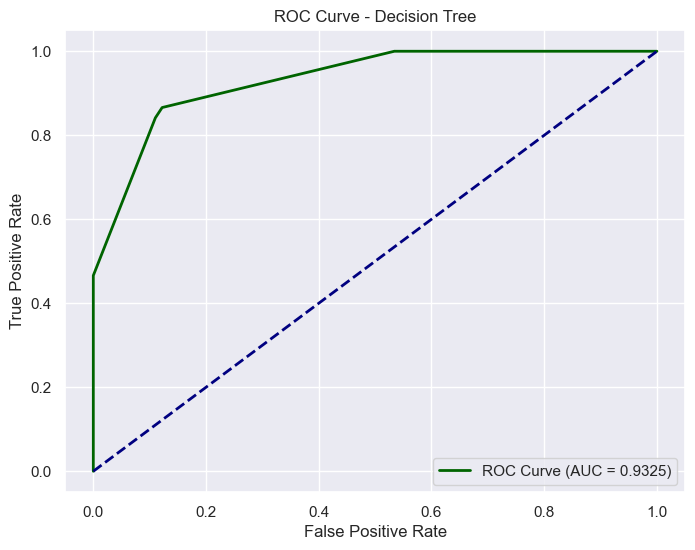

In [59]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(ytest, yproba[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkgreen', lw=2, label='ROC Curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC Curve - Decision Tree')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# **XGBoost**

In [60]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define model and parameter grid
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
param = {
    'n_estimators': [100, 150],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}

In [61]:
# 2. Grid Search
gridSearch = GridSearchCV(xgb, param, cv=5, scoring='accuracy')
gridSearch.fit(xtrain_scaled, ytrain)

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'learning_rate': [0.01, 0.1, ...], 'max_depth': [3, 6, ...], 'n_estimators': [100, 150]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [62]:
# 3. Get best model and train
XGB = gridSearch.best_estimator_
XGB.fit(xtrain_scaled, ytrain)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [63]:
# 4. Predict
ypred = XGB.predict(xtest_scaled)
yproba = XGB.predict_proba(xtest_scaled)

print('Model Accuracy Score: {0:0.4f}'.format(accuracy_score(ytest, ypred)))

Model Accuracy Score: 0.9712


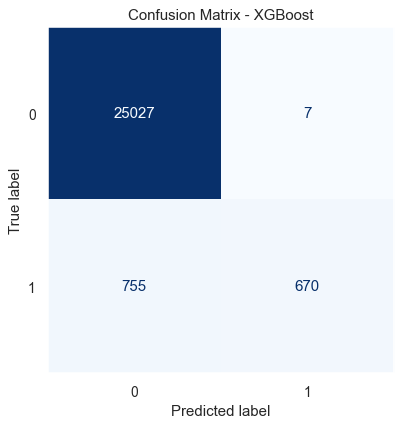

In [64]:
# 5. Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 5), dpi=90)
sns.set_style('darkgrid')
ConfusionMatrixDisplay.from_estimator(XGB, xtest_scaled, ytest, ax=ax, colorbar=False, cmap='Blues')
plt.title('Confusion Matrix - XGBoost')
plt.grid(False)
plt.show()

In [65]:
# 6. Metrics
xgb_result = metrics_calculator(ytest, ypred, 'XGBoost', yproba)
print(xgb_result)

            XGBoost
Accuracy   0.971201
Precision  0.980188
Recall     0.734948
F1-score   0.811246
ROC AUC    0.963850


In [66]:
# 7. Best hyperparameters
print("Best Parameters:", gridSearch.best_params_)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


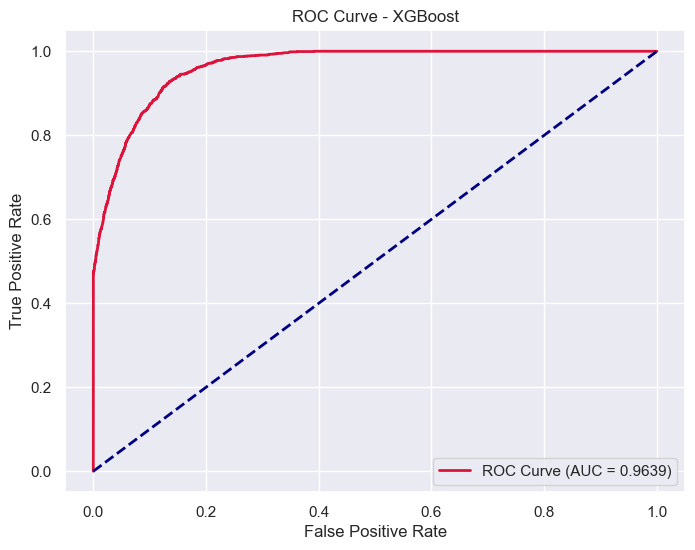

In [67]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(ytest, yproba[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='crimson', lw=2, label='ROC Curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC Curve - XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# **Combined Result**

In [68]:
# 📊 Combine them side by side
combined_results = pd.concat([
    knn_result,
    lg_result,
    svm_result,
    dt_result,
    xgb_result
], axis=1)

# 📌 Show full table
print("📊 Model Performance Comparison:")
display(combined_results)


📊 Model Performance Comparison:


,KNN,Logistic Regression,SVM,Decision Tree,XGBoost
Accuracy,0.960203,0.960921,0.964511,0.971239,0.971201
Precision,0.890947,0.878762,0.955788,0.985249,0.980188
Recall,0.665602,0.683189,0.680123,0.732982,0.734948
F1-score,0.727587,0.742932,0.752339,0.810370,0.811246
ROC AUC,0.851355,0.938097,0.895797,0.932504,0.963850


In [69]:
# Sort by Accuracy
combined_results.sort_values(by='Accuracy', axis=1, ascending=False)


,Decision Tree,XGBoost,SVM,Logistic Regression,KNN
Accuracy,0.971239,0.971201,0.964511,0.960921,0.960203
Precision,0.985249,0.980188,0.955788,0.878762,0.890947
Recall,0.732982,0.734948,0.680123,0.683189,0.665602
F1-score,0.810370,0.811246,0.752339,0.742932,0.727587
ROC AUC,0.932504,0.963850,0.895797,0.938097,0.851355


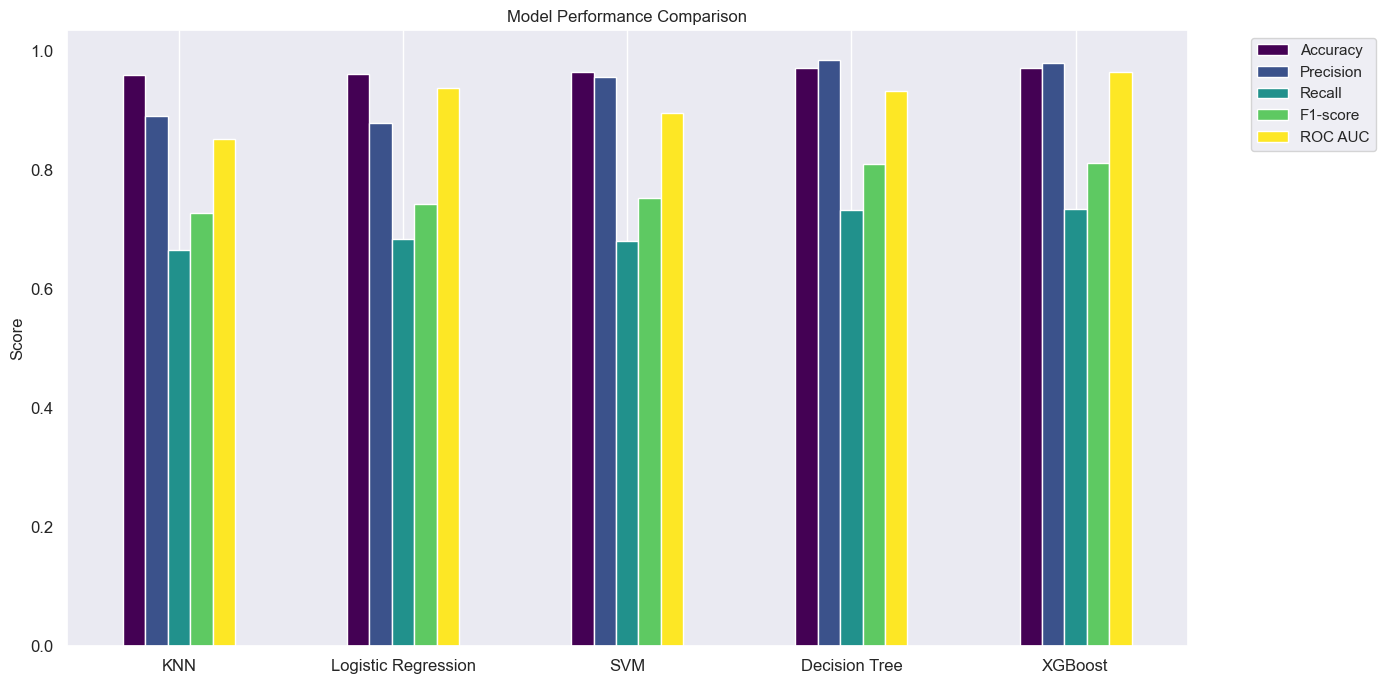

In [70]:
combined_results.T.plot.bar(
    figsize=(14, 7),
    rot=0,
    title='Model Performance Comparison',
    colormap='viridis',
    ylabel='Score'
)
plt.grid(axis='y')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


ONLY NEW

In [71]:
import joblib

# Let's assume your trained model object is named 'xgboost_model'
# Replace 'xgboost_model' with the actual name of your model variable if it's different.

# The path needs to go "up one level" from the notebooks folder 
# and then "down into" the models folder. '../' means go up one level.
model_filepath = "../models/best_model_xgboost_v1.pkl"

print(f"Saving model to: {model_filepath}")
joblib.dump(XGB, model_filepath)
print("Model saved successfully!")

Saving model to: ../models/best_model_xgboost_v1.pkl
Model saved successfully!


Save Model

In [ ]:
import joblib

# Save model to disk
joblib.dump(XGB, 'best_model_xgboost.joblib')


load model

In [ ]:
# Load model from disk
loaded_model = joblib.load('best_model_xgboost.joblib')

# Predict using loaded model
y_new_pred = loaded_model.predict(xtest_scaled)


Predict

In [ ]:
def predict_diabetes(input_dict, model, scaler, feature_columns):
    """
    Predicts diabetes based on user input.

    Parameters:
    - input_dict (dict): User-provided input in dict form.
    - model: Trained classifier (e.g., XGB, SVM, etc.)
    - scaler: Fitted StandardScaler
    - feature_columns: List of columns used in training (after get_dummies)

    Returns:
    - prediction (0 or 1)
    - probability of having diabetes
    """

    import pandas as pd
    import numpy as np

    # Convert dict to DataFrame
    new_data = pd.DataFrame([input_dict])

    # Add missing dummy columns (if any) to match training columns
    for col in feature_columns:
        if col not in new_data.columns:
            new_data[col] = 0

    # Reorder columns to match training data
    new_data = new_data[feature_columns]

    # Scale
    new_data_scaled = scaler.transform(new_data)

    # Predict
    prediction = model.predict(new_data_scaled)[0]
    probability = model.predict_proba(new_data_scaled)[0][1]

    return prediction, probability


In [ ]:
# Set this once — use your final model, scaler, and training feature columns
best_model = XGB              # Or any model you choose
trained_scaler = scaler       # Your StandardScaler used on training data
feature_columns = data.columns.tolist()  # After all preprocessing (including get_dummies)


In [ ]:
sample_input = {
    'age': 52,
    'bmi': 27.6,
    'HbA1c_level': 6.2,
    'blood_glucose_level': 180,

    # Categorical dummy features (must match training)
    'gender_Male': 1,
    'gender_Other': 0,

    'smoking_history_current': 0,
    'smoking_history_ever': 0,
    'smoking_history_former': 1,
    'smoking_history_never': 0,
    'smoking_history_no_info': 0,
    'smoking_history_not_current': 0
}

pred, prob = predict_diabetes(sample_input, best_model, trained_scaler, feature_columns)
print(f"Prediction: {'Diabetic' if pred == 1 else 'Not Diabetic'}")
print(f"Probability: {prob:.4f}")


Streamlit

In [ ]:
import joblib

# Save the trained model
joblib.dump(XGB, 'model_xgb.joblib')

# Save the fitted scaler
joblib.dump(scaler, 'scaler.joblib')

# Save the final column names
joblib.dump(data.columns.tolist(), 'feature_columns.joblib')


**NEW ONES DEPLOY**